In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout  # Ensure Dropout is imported
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Import r2_score
import matplotlib.pyplot as plt

2024-11-26 15:17:14.307838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 15:17:14.443707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda/lib64:
2024-11-26 15:17:14.443732: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-26 15:17:15.223725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so

In [2]:
# Load the dataset
df = pd.read_csv('data/synthetic_dataset.csv')

# Extract input features and target
X_columns = []
for day in range(1, 5):
    X_columns.extend([f'day{day}_temp', f'day{day}_speed', f'day{day}_pollution'])

y_column = 'day5_pollution'

X = df[X_columns].values
y = df[y_column].values

# Reshape X to (samples, timesteps, features)
X = X.reshape((X.shape[0], 4, 3))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
nsamples_train, timesteps, nfeatures = X_train.shape
nsamples_test = X_test.shape[0]

# Reshape for scaling
X_train_reshaped = X_train.reshape((nsamples_train * timesteps, nfeatures))
X_test_reshaped = X_test.reshape((nsamples_test * timesteps, nfeatures))

In [3]:
# Initialize scaler
scaler = MinMaxScaler()
# Fit scaler on training data
scaler.fit(X_train_reshaped)

# Transform data
X_train_scaled = scaler.transform(X_train_reshaped).reshape((nsamples_train, timesteps, nfeatures))
X_test_scaled = scaler.transform(X_test_reshaped).reshape((nsamples_test, timesteps, nfeatures))

# Scale the target variable
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train)

y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [4]:
# Build the RNN model
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=False, input_shape=(timesteps, nfeatures)))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=16,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=1
)

2024-11-26 15:17:54.721885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-26 15:17:54.721957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-104S604): /proc/driver/nvidia/version does not exist
2024-11-26 15:17:54.722931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
50/50 [==============================] - 2s 14ms/step - loss: 0.0977 - val_loss: 0.0547
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0573 - val_loss: 0.0358
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0127
Epoch 4/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0181 - val_loss: 0.0106
Epoch 5/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0104
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0131 - val_loss: 0.0074
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.0075
Epoch 8/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.0068
Epoch 9/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.0069
Epoch 10/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 0.0067
Epoch 11

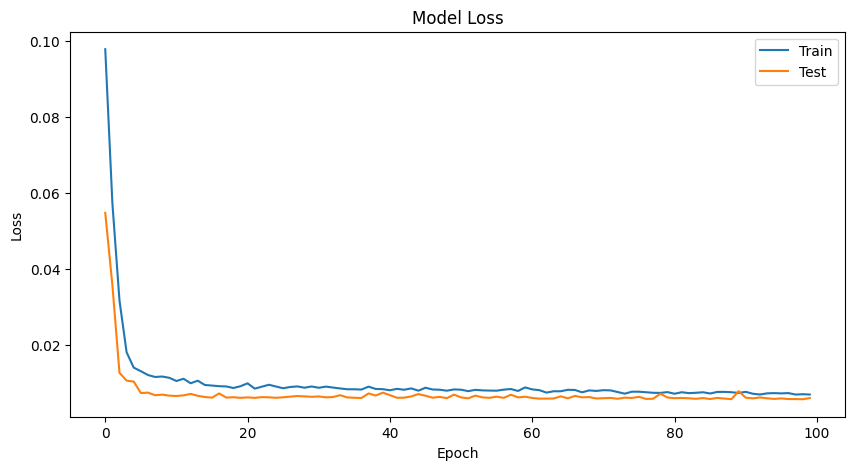

In [5]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Evaluate the model
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  # Calculate R² score
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Display the results
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.2f}")
print(f"Test MAPE: {mape:.2f}%")

7/7 [==============================] - 0s 4ms/step
Test MSE: 38.7716
Test MAE: 5.0244
Test R²: 0.91
Test MAPE: 5.09%


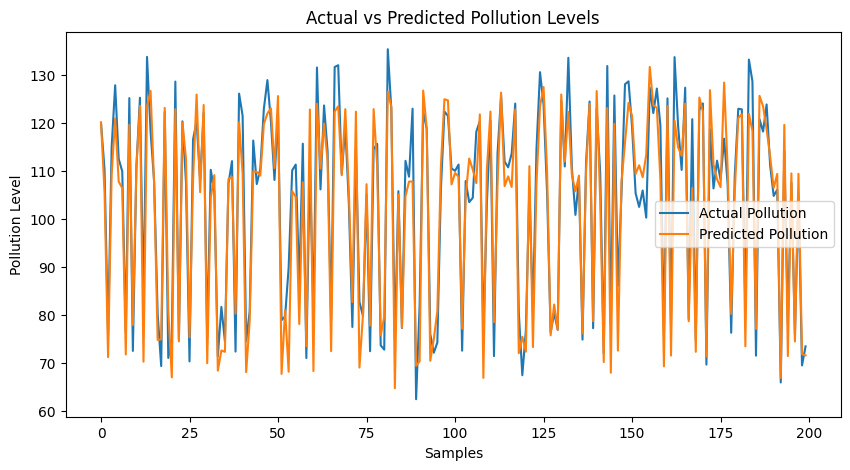

In [7]:
# Plot actual vs predicted pollution levels
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Pollution')
plt.plot(y_pred, label='Predicted Pollution')
plt.title('Actual vs Predicted Pollution Levels')
plt.xlabel('Samples')
plt.ylabel('Pollution Level')
plt.legend()
plt.show()